In [1]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook

Using TensorFlow backend.


In [2]:
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [3]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\zceecyt-AMLSassignment19_20-16053203\\Project-16053203\\Notebook\\B2'

In [34]:
df = pd.read_csv('../../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[2]])
df['eye_color'] = df['eye_color'].apply(str)
df

eye_color file_name
0            1     0.png
1            2     1.png
2            2     2.png
3            2     3.png
4            0     4.png
...        ...       ...
9995         3  9995.png
9996         0  9996.png
9997         1  9997.png
9998         0  9998.png
9999         2  9999.png

[10000 rows x 2 columns]

In [35]:
img = ('../../Dataset_original_AMLS_19-20/cartoon_set/img')
# training, testing = train_test_split(df, random_state=0)
for x in [0.6,0.65,0.7,0.75,0.8]:
    for y in [0.8,0.8,0.85,0.85,0.9]: #help
        training, validating, testing = np.split(df.sample(frac=1), [int(x*len(df)), int(y*len(df))]) #splitting at n-array
# print(training, validating, testing)
#         print(training)

In [36]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    horizontal_flip=True,
    vertical_flip=True   
)

# # get batches of training images from the df
# train_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# validate_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "eye_color",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = validating, directory = img ,
        x_col = "file_name", y_col = "eye_color",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')

Training Dataset Preparation: 
Found 8000 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 1000 validated image filenames belonging to 5 classes.


In [37]:
# starting point 
my_model= models.Sequential()

# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                    input_shape=(30,30,3))) #height, width, depth
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# global average pooling
#my_model.add(GlobalAveragePooling2D())
# fully connected layer
#my_model.add(Dense(64, activation='relu'))
#my_model.add(BatchNormalization())
# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)        

In [38]:
# # use early stopping to optimally terminate training through callbacks

# es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # save best model automatically
# mc= ModelCheckpoint('/../../dataset/cartoon_set', monitor='val_loss', 
#                     mode='min', verbose=1, save_best_only=True)
# cb_list=[es,mc]


# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [39]:
batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=25,
                                steps_per_epoch=train_generator.samples // batch_size,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // batch_size
                                )

Epoch 1/25
250/250 [==============================] - 190s 760ms/step - loss: 1.6126 - accuracy: 0.1940 - val_loss: 1.6072 - val_accuracy: 0.1835
Epoch 2/25
250/250 [==============================] - 142s 566ms/step - loss: 1.6098 - accuracy: 0.1970 - val_loss: 1.6115 - val_accuracy: 0.1860
Epoch 3/25
250/250 [==============================] - 138s 554ms/step - loss: 1.6096 - accuracy: 0.1996 - val_loss: 1.6104 - val_accuracy: 0.1829
Epoch 4/25
250/250 [==============================] - 138s 550ms/step - loss: 1.6098 - accuracy: 0.1972 - val_loss: 1.6098 - val_accuracy: 0.1860
Epoch 5/25
250/250 [==============================] - 139s 557ms/step - loss: 1.6095 - accuracy: 0.2037 - val_loss: 1.6103 - val_accuracy: 0.2004
Epoch 6/25
250/250 [==============================] - 130s 519ms/step - loss: 1.6096 - accuracy: 0.2014 - val_loss: 1.6094 - val_accuracy: 0.1736
Epoch 7/25
250/250 [==============================] - 93s 373ms/step - loss: 1.6062 - accuracy: 0.2021 - val_loss: 1.6079 - 

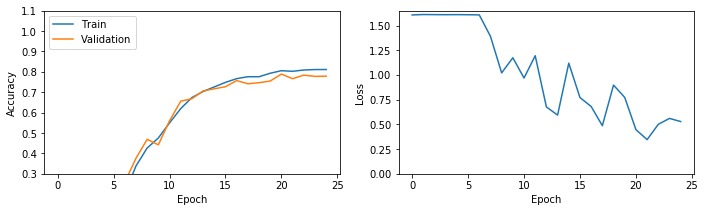

In [49]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.3,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['val_loss'])
plt.ylim([0,1.65])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [41]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

my_model.save(modelFile)

In [ ]:
df2 = pd.read_csv('../../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[2]])
df2['eye_color'] = df2['eye_color'].apply(str)
df2

In [ ]:
img = ('../../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [42]:
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "eye_color",
#         batch_size=1,
#         class_mode='categorical', target_size=(30, 30),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "eye_color",
        batch_size=1,
        class_mode='categorical', target_size=(30, 30),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 1000 validated image filenames belonging to 5 classes.
1000


In [43]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

1000/1000 [==============================] - 12s 12ms/step


In [44]:
import sklearn.metrics as metrics

Classification Report
[[0.161 0.011 0.008 0.018 0.007]
 [0.009 0.168 0.005 0.021 0.001]
 [0.016 0.011 0.149 0.017 0.004]
 [0.005 0.024 0.006 0.155 0.006]
 [0.011 0.008 0.001 0.015 0.163]]
Confusion Matrix


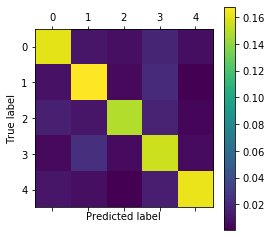

In [45]:
cm = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')
print('Classification Report')
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Confusion Matrix')
plt.show()

In [46]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2507.780282020569 seconds ---
